In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/SOCOFing.zip

In [3]:
import os
from collections import defaultdict
import cv2
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

from keras.optimizers import RMSprop
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from inception_block_model import imgRecoModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [5]:
altered_path = 'SOCOFing/Altered/Altered'
real_path = 'SOCOFing/Real'

dic_alt_easy = get_data_dic(altered_path + '-Easy')
dic_alt_hard = get_data_dic(altered_path + '-Hard')
dic_alt_med = get_data_dic(altered_path + '-Medium')
dic_real = get_data_dic(real_path, train=False)

In [6]:
def merge_data(dic1, dic2, dic3):
    
    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2
        
    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3
        
    return dic1

In [7]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [8]:
ids = list(dic_data.keys())
len(ids)

6000

In [9]:
def get_train_data(ids, dic_data):
  while True:
    [id_ap, id_n] = np.random.choice(ids, size=2, replace=False)
    [anc_img, pos_img] = np.random.choice(dic_data[id_ap], size=2, replace=False)
    neg_img = np.random.choice(dic_data[id_n], replace=False)

    anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
    pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
    neg_img = np.around(np.transpose(cv2.resize(cv2.imread(neg_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)

    yield [anc_img, pos_img, neg_img]

In [10]:
def get_batch_data(batch_size, ids, dic_data):

  gen = get_train_data(ids, dic_data)
  x_train = np.zeros((batch_size, 2, 3, 96, 96))
  y_train = np.zeros((batch_size, 1))

  while True:
    for i in range(1, batch_size, 2):
      anc_img, pos_img, neg_img = next(gen)
      x_train[i-1, 0, :, :, :] = anc_img
      x_train[i-1, 1, :, :, :] = pos_img
      y_train[i-1, :] = 1
      x_train[i, 0, :, :, :] = anc_img
      x_train[i, 1, :, :, :] = neg_img
      y_train[i, :] = 0

    x_data = {
        'first_input': x_train[:, 0, :, :, :],
        'second_input': x_train[:, 1, :, :, :]
    }
    yield (x_data, y_train)

In [11]:
def draw_data(num):
  gen = get_batch_data(num, ids, dic_data)
  x, y = next(gen)
  x1 = np.transpose(x['first_input'], (0, 2, 3, 1))
  x2 = np.transpose(x['second_input'], (0, 2, 3, 1))
  fig, ax = plt.subplots(num, 2, figsize=(10, 20))
  for i in range(num):
    ax[i][0].imshow(x1[i])
    ax[i][1].imshow(x2[i])
    if y[i] == 1:
      ax[i][0].title.set_text('Anchor')
      ax[i][1].title.set_text('Positive')
    else:
      ax[i][0].title.set_text('Anchor')
      ax[i][1].title.set_text('Negative')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

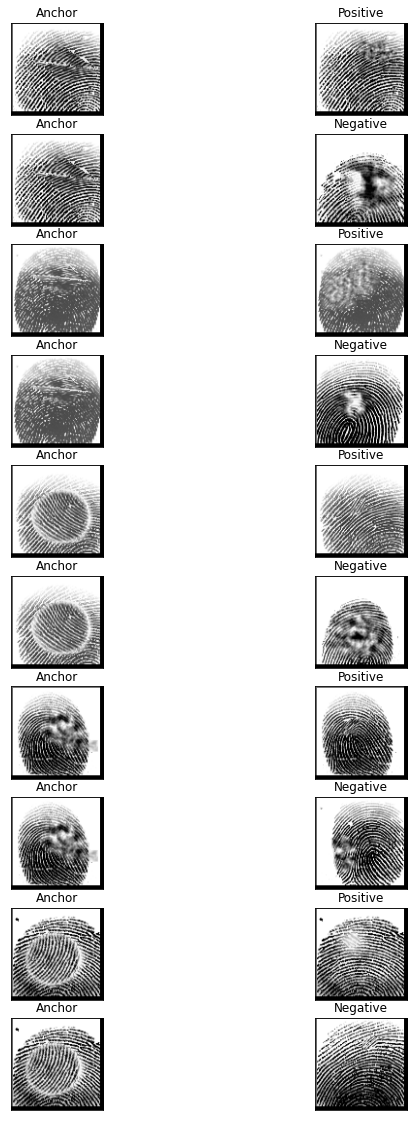

In [12]:
draw_data(10)

In [13]:
batch_size = 32
train_gen = get_batch_data(batch_size, ids, dic_data)

In [14]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [15]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [16]:
input_shape = (3, 96, 96)
network = imgRecoModel(input_shape)
siam_network = build_network(network, input_shape)
siam_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_input (InputLayer)        [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
second_input (InputLayer)       [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
ImgRecoModel (Functional)       (None, 128)          3743280     first_input[0][0]                
                                                                 second_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           ImgRecoModel[0][0]           

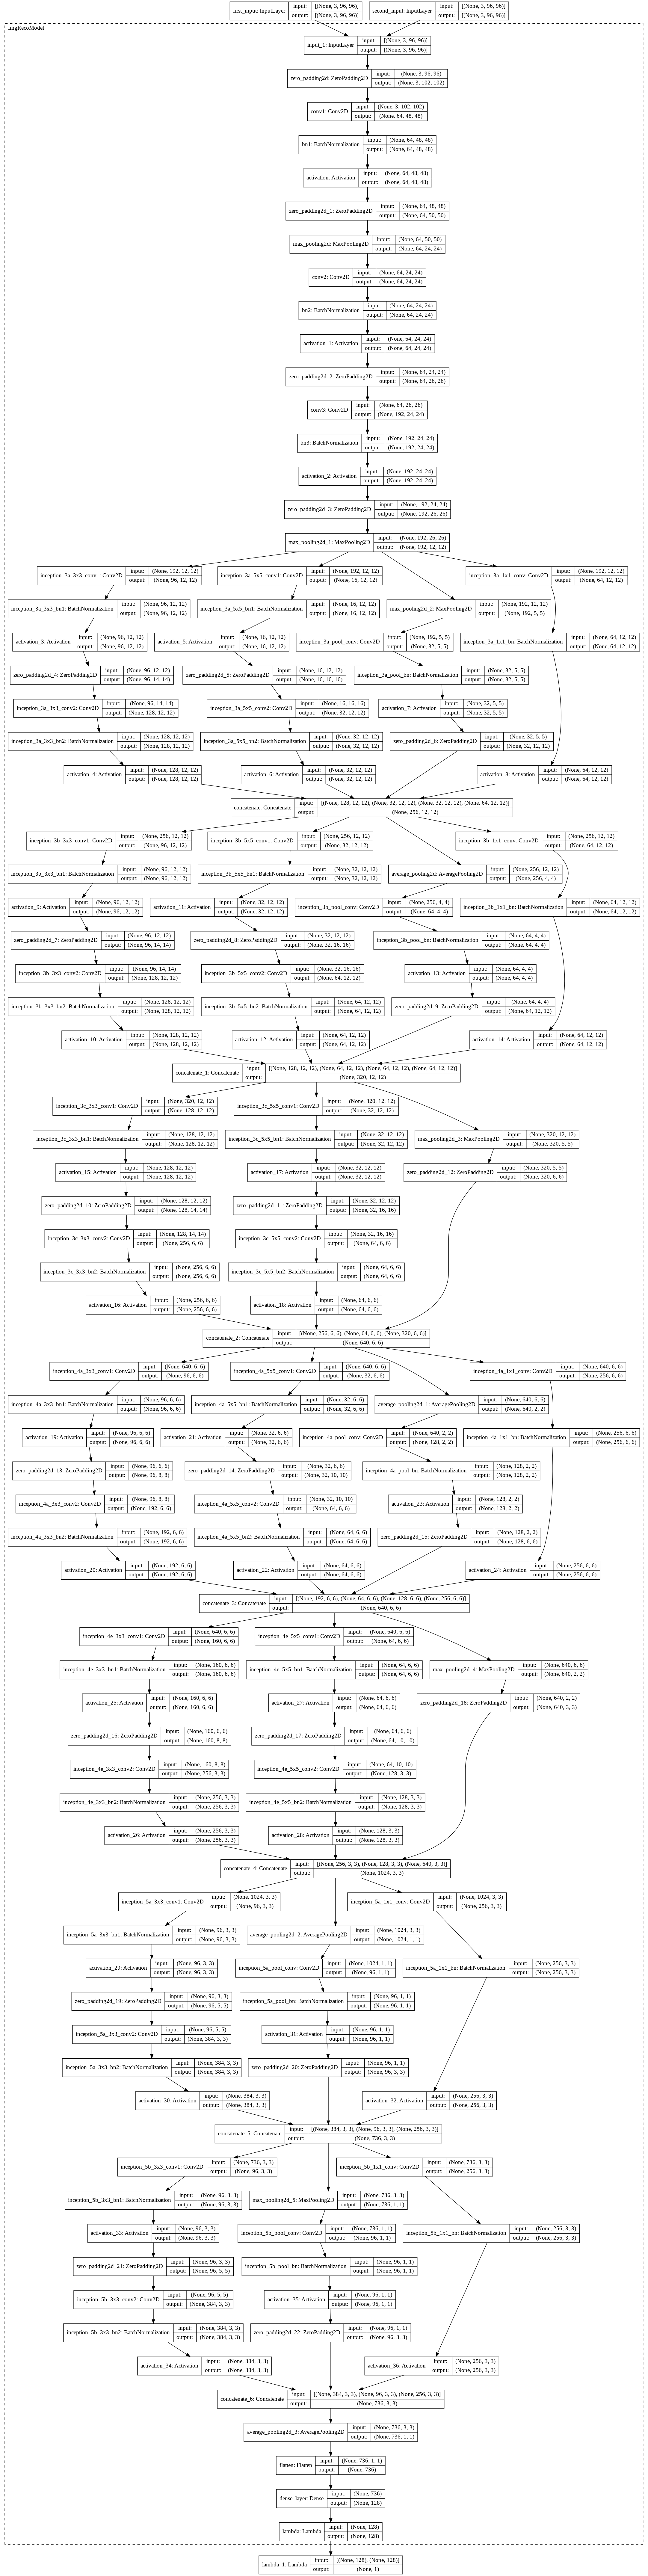

In [17]:
plot_model(siam_network, show_shapes=True, expand_nested=True)

In [18]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=8,
    restore_best_weights=True
)

In [19]:
rms = RMSprop()
siam_network.compile(loss=contrastive_loss_with_margin(margin=2), optimizer=rms)

In [20]:
history = siam_network.fit(train_gen, epochs=200, steps_per_epoch=64, callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 48s 91ms/step - loss: 0.6318
Epoch 2/200
64/64 [==============================] - 6s 91ms/step - loss: 0.4039
Epoch 3/200
64/64 [==============================] - 6s 90ms/step - loss: 0.3830
Epoch 4/200
64/64 [==============================] - 6s 90ms/step - loss: 0.3408
Epoch 5/200
64/64 [==============================] - 6s 89ms/step - loss: 0.3365
Epoch 6/200
64/64 [==============================] - 6s 90ms/step - loss: 0.3083
Epoch 7/200
64/64 [==============================] - 6s 90ms/step - loss: 0.3173
Epoch 8/200
64/64 [==============================] - 6s 90ms/step - loss: 0.3247
Epoch 9/200
64/64 [==============================] - 6s 91ms/step - loss: 0.2978
Epoch 10/200
64/64 [==============================] - 6s 92ms/step - loss: 0.2925
Epoch 11/200
64/64 [==============================] - 6s 93ms/step - loss: 0.2915
Epoch 12/200
64/64 [==============================] - 6s 92ms/step - loss: 0.2649
Epoch 13/200
64/64 [====

In [21]:
irm = siam_network.get_layer(index=2)
w = irm.get_weights()
p = imgRecoModel(input_shape)
p.set_weights(w)

In [22]:
p.save('model_siamese_net1_r.h5')

In [39]:
id_real = list(dic_real.keys())
len(id_real)

6000

In [47]:
def compute_distance():
  [anc_pos, neg] = np.random.choice(ids, size=2, replace=False)

  anc_img = dic_real[anc_pos][0]
  pos_img = np.random.choice(dic_data[anc_pos])
  neg_img = np.random.choice(dic_data[neg])

  anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
  pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)
  neg_img = np.around(np.transpose(cv2.resize(cv2.imread(neg_img), (96, 96))/255.0, (2, 0, 1)), decimals=6)

  pos_enc = p.predict_on_batch(np.expand_dims(pos_img, 0))
  anc_enc = p.predict_on_batch(np.expand_dims(anc_img, 0))
  neg_enc = p.predict_on_batch(np.expand_dims(neg_img, 0))

  print('Distance between anchor - positive: ', np.linalg.norm(anc_enc - pos_enc))
  print('Distance between anchor - negative: ', np.linalg.norm(anc_enc - neg_enc))

  fig, ax = plt.subplots(1, 3, figsize=(10, 4))
  ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))
  ax[0].title.set_text('Anchor Image')
  ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))
  ax[1].title.set_text('Positive Image')
  ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))
  ax[2].title.set_text('Negative Image')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

Distance between anchor - positive:  0.13337995
Distance between anchor - negative:  1.3731352


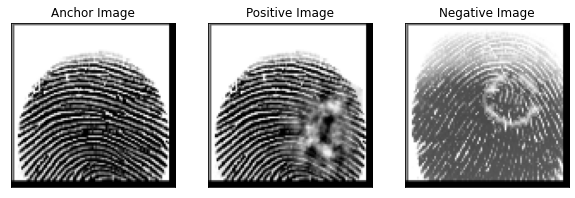

In [68]:
# Every time you run this cell you will get different image set
compute_distance()